# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Coupled soil root hydraulics - the alpha and omega of RWU (Vanderborght et al. 2024)


In [7]:
import os
sourcedir = os.getcwd()+"/../../../"
#sourcedir = "/opt/dumux/CPlantBox/"
import sys;  
sys.path.append(sourcedir+"../dumux-rosi/python/modules");
sys.path.append(sourcedir+"../dumux-rosi/build-cmake/cpp/python_binding/");
sys.path.append(sourcedir)  
sys.path.append(sourcedir+"src") 

import plantbox as pb
import visualisation.vtk_plot as vp
from functional.PlantHydraulicParameters import PlantHydraulicParameters
from functional.PlantHydraulicModel import HydraulicModel_Doussan
from functional.PlantHydraulicModel import HydraulicModel_Meunier
from functional.Perirhizal import PerirhizalPython as Perirhizal
import functional.van_genuchten as vg

from rosi_richards import RichardsSP  # C++ part (Dumux binding)
from richards import RichardsWrapper  # Python part
import numpy as np
import matplotlib.pyplot as plt
import figure_style
import timeit

In [11]:
def sinusoidal(t):
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.


def make_source(q, area):
    s = {}
    for i in range(0, len(q)):
        if not np.isnan(q[i]):
            s[i] = -q[i] * area

    return s


""" Parameters """  # |\label{l7xa:param}|
verbose = False
depth = -100
N = 100
min_b = [-10., -10., depth]  # [cm]
max_b = [10., 10., 0.]  # [cm]
cell_number = [1, 1, N]  # [cm3]

kx = 10 * 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]

path = sourcedir + "modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified"  #"Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010, Zeamays_synMRI.xml  <<<<-------
trans = 1.5 * 400  # cm3 /day (sinusoidal) = mL/day
wilting_point = -15000  # cm
rs_age = 60  # root system initial age [day]

loam = [0.01, 0.43, 0.0083, 1.2539, 2.272]  # jan paper
sp = vg.Parameters(loam)  # needed for Perirhizal class
vg.create_mfp_lookup(sp, wilting_point = -16000, n = 1501)  # needed for Perirhizal class
initial = -500  # cm (-330 )

sim_time = 7  # [day]
dt = 3600. / (24 * 3600)  # [days]  # |\label{l7xa:param_end}|


initializing look up tables
done


In [12]:

""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())  
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic = True)  # [cm]
s.setHomogeneousIC(initial, False)  # [cm] False = matrix, True, = total potential
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([loam])
s.setParameter("Soil.SourceSlope", "100") 
s.initializeProblem()
s.setCriticalPressure(wilting_point)  

""" Initialize xylem model """
plant = pb.MappedPlant() 
plant.enableExtraNode()
plant.readParameters(path + name + ".xml")
sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2] - 0.5)  
plant.setGeometry(sdf)  
plant.setRectangularGrid(pb.Vector3d(min_b), pb.Vector3d(max_b), pb.Vector3d(cell_number), False, False)  # needed for Perirhizal class

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.read_parameters(sourcedir + "modelparameter/functional/plant_hydraulics/couvreur2012")
# params.set_kr_const(kr)
# params.set_kx_const(kx)
# params.plot_conductivities(True) 
hm = HydraulicModel_Doussan(plant, params)
hm.wilting_point = wilting_point  

""" Coupling (map indices) """
picker = lambda x, y, z: s.pick([0, 0, z]) 
plant.setSoilGrid(picker)
plant.initialize(True)
plant.simulate(rs_age, True)
hm.test() 

peri = Perirhizal(plant)
h_bs = s.getSolutionHead()
h_sr = np.ones(h_bs.shape) * wilting_point


Computed bounding box tree with 199 nodes for 100 grid entities in 4.0741e-05 seconds.
Computed bounding box tree with 199 nodes for 100 grid entities in 2.2043e-05 seconds.
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 60 days
nodes moved 0
new nodes added 54110
segments added 54110
Number of segments 54111, including 54110 new 
PlantHydraulicModel.test():
54112 nodes:
Node 0 [ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [ 0.05597242  0.04792876 -3.49454011]
Node 3 [ 0.12251728  0.06718754 -3.98971774]
Node 4 [ 0.15243177  0.05177603 -4.36485145]
54111 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 1
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments with length < 1.e-5 cm
6 different root types from 0 to 5
ages from 0 to 60
segments 54111 54111

In [13]:
""" Numerical solution """
start_time = timeit.default_timer()
t = 0.
x_, y_ = [], []
N = round(sim_time / dt)
area = (plant.maxBound.x - plant.minBound.x) * (plant.maxBound.y - plant.minBound.y)  # [cm2]

for i in range(0, N): 

    h_bs = s.getSolutionHead()
    h_bs = np.array(plant.matric2total(h_bs))

    start_time_ao = timeit.default_timer()

    hm.update(rs_age + sim_time)

    # Alpha: root system averaged stress factor
    # krs, _ = hm.get_krs(rs_age + sim_time)  # [cm2/day] (could be precomputed for static case)
    krs = hm.krs
    krs = krs / area
    if verbose:
        print("krs", krs)

    k_srs = hm.get_soil_rootsystem_conductance(rs_age + sim_time, h_bs, wilting_point, sp)
    h_bs_diff = h_bs - np.ones(h_bs.shape) * wilting_point
    alpha = np.multiply(k_srs, h_bs_diff) / (-krs * wilting_point)  # [1]

    # Omega: root system averaged stress factor
    # suf_ = hm.get_suf(rs_age + sim_time)
    suf_ = hm.suf
    suf = peri.aggregate(suf_[0,:])
    alphaSUF = np.multiply(alpha, suf)
    omega = np.nansum(alphaSUF)  # note that nan are treated as 0
    if verbose:
        print("omega", omega)

    # Omega_c: critical stress factor
    tp = trans * sinusoidal(t) / area  # potential tranpiration [cm3 day-1] -> [cm day-1]
    # print("tp", tp)
    omega_c = tp / (-wilting_point * krs)
    if verbose:
        print("max uptake", (-wilting_point * krs), tp)
        print("omega_c", omega_c)
        print("omega / omega_c", omega / omega_c)

    # Sink, stressed
    q_s = alphaSUF * tp / omega_c

    # Sink, unstressed
    denumerator = np.multiply(h_bs_diff, np.nansum(np.divide(alphaSUF, h_bs_diff)))
    if verbose:
        print("denumerator", np.nansum(denumerator), np.nanmin(denumerator), np.nanmax(denumerator))
        print("- term: ", np.nansum(np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp))
    q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp

    if verbose:
        print("pot", tp, "q_us", np.nansum(q_us), "q_s", np.nansum(q_s))

    if omega < omega_c:
        print("stressed")
        q = q_s
    else:
        print("unstressed")
        q = q_us

    start_time_soil = timeit.default_timer()

    fluxes = make_source(q, area)
    s.setSource(fluxes)
    s.solve(dt) 

    final_time = timeit.default_timer()

    x_.append(t)
    y_.append(-np.nansum(q) * area) 

    n = round(float(i) / float(N) * 100.)  
    print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], potential {:g}, actual {:g}; [{:g}, {:g}] cm soil at {:g} days"
            .format(tp * area, np.nansum(q) * area, np.min(h_bs), np.max(h_bs), s.simTime))

    print("wall times:", (start_time_ao - start_time_soil) / (start_time_ao - final_time), (start_time_soil - final_time) / (start_time_ao - final_time))

    t += dt  # [day]

print ("Coupled benchmark solved in ", timeit.default_timer() - start_time, " s")  # |\label{l7xa:timing}|


/tmp/ipykernel_419486/1843495467.py:47: RuntimeWarning: invalid value encountered in divide
  q_s = alphaSUF * tp / omega_c
/tmp/ipykernel_419486/1843495467.py:54: RuntimeWarning: invalid value encountered in divide
  q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp
/tmp/ipykernel_419486/1843495467.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp
/tmp/ipykernel_419486/1843495467.py:54: RuntimeWarning: invalid value encountered in multiply
  q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp


unstressed
[                                                                                                    ], potential 0, actual 0; [-510.638, -503] cm soil at 0.0416667 days
wall times: 0.9857901406535364 0.0142098593464636
unstressed
[*                                                                                                   ], potential 20.4445, actual 20.4445; [-510.754, -502.545] cm soil at 0.0833333 days
wall times: 0.9871501489686711 0.012849851031328897
unstressed
[*                                                                                                   ], potential 80.3848, actual 80.3848; [-510.952, -502.212] cm soil at 0.125 days
wall times: 0.9916126373005832 0.008387362699416711
unstressed
[**                                                                                                  ], potential 175.736, actual 175.736; [-511.544, -501.949] cm soil at 0.166667 days
wall times: 0.9921367115077485 0.007863288492251487
unstressed
[**             

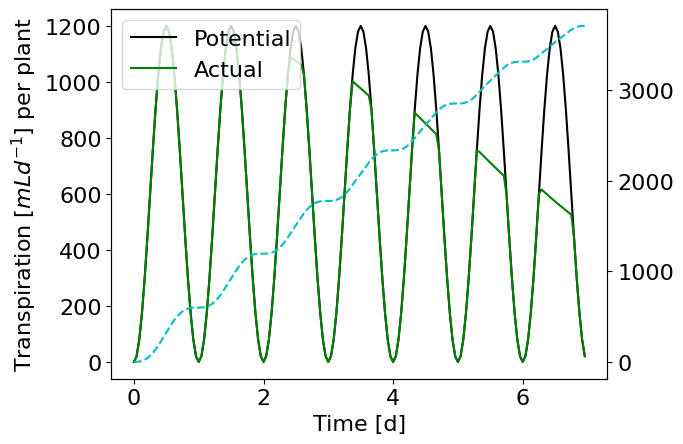

In [6]:
""" Transpiration over time """
fig, ax1 = plt.subplots()
ax1.plot(x_, trans * sinusoidal(x_), 'k')  # potential transpiration
ax1.plot(x_, -np.array(y_), 'g')  # actual transpiration
ax2 = ax1.twinx()
ax2.plot(x_, np.cumsum(-np.array(y_) * dt), 'c--')  # cumulative transpiratio
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
plt.show()